# Satellite data 

This notebook loads Copernicus Marine daily L4 SST files (from `....ipynb`) and computes monthly SST anomalies, plus quick maps and a time series (2020-2024). (Might need to edit name opf the Copernicus SSt file)

Here I am looking at what satellite data says, I am considering at investigating SST, 


In [12]:
# 1) Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# SST
Here I am looking at intraannual SST spatiotemporal variability

In [13]:
ds = xr.open_dataset("../data/satellite/CMEMS_cmems_obs-sst_glo_phy_nrt_l4_P1D-m_2021-2024.nc")
ds

<xarray.Dataset> Size: 3GB
Dimensions:           (time: 1461, latitude: 300, longitude: 300)
Coordinates:
  * latitude          (latitude) float32 1kB 50.05 50.15 50.25 ... 79.85 79.95
  * longitude         (longitude) float32 1kB -39.95 -39.85 ... -10.15 -10.05
  * time              (time) datetime64[ns] 12kB 2021-01-01 ... 2024-12-31
Data variables:
    analysed_sst      (time, latitude, longitude) float64 1GB ...
    analysis_error    (time, latitude, longitude) float64 1GB ...
    mask              (time, latitude, longitude) int8 131MB ...
    sea_ice_fraction  (time, latitude, longitude) float64 1GB ...
Attributes:
    contact:                   emmanuelle.autret@ifremer.fr;jfpiolle@ifremer.fr
    history:                   Optimally interpolated SST originally produced...
    source:                    Odyssea L4 processor
    title:                     ODYSSEA Global Sea Surface Temperature Gridded...
    references:                Product User Manual for L4 Odyssea Product ove...
    institution:               Institut Francais de Recherche pour l'Exploita...
    Conventions:               CF-1.7, ACDD-1.3, ISO 8601
    copernicusmarine_version:  2.2.1

In [14]:
sst =ds['analysed_sst']
sst = sst - 273.15  # Convert from Kelvin to Celsius
sst = sst.rename('degC')  # Rename variable for convenience

### Cropping of study location
Not needed as data downloaded to exact location

In [15]:
# Example: same bounds as downloader
lat_name = "lat" if "lat" in sst.dims else "latitude"
lon_name = "lon" if "lon" in sst.dims else "longitude"

# If your longitude is 0..360 and you want negatives, you can convert once:
# if sst[lon_name].max() > 180:
#     sst = sst.assign_coords({lon_name: (((sst[lon_name] + 180) % 360) - 180)}).sortby(lon_name)

sst = sst.sel({lat_name: slice(55, 75), lon_name: slice(-35, -15)})
sst

<xarray.DataArray 'degC' (time: 1461, latitude: 200, longitude: 200)> Size: 468MB
array([[[ 6.44,  6.5 ,  6.57, ..., 10.34, 10.37, 10.4 ],
        [ 6.45,  6.51,  6.58, ..., 10.32, 10.36, 10.39],
        [ 6.42,  6.49,  6.56, ..., 10.3 , 10.34, 10.35],
        ...,
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ]],

       [[ 6.45,  6.5 ,  6.58, ..., 10.33, 10.35, 10.39],
        [ 6.38,  6.45,  6.57, ..., 10.27, 10.31, 10.35],
        [ 6.37,  6.44,  6.52, ..., 10.25, 10.29, 10.33],
        ...,
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ]],

       [[ 6.44,  6.48,  6.53, ..., 10.26, 10.28, 10.31],
        [ 6.38,  6.44,  6.51, ..., 10.24, 10.25, 10.27],
        [ 6.39,  6.44,  6.51, ..., 10.19, 10.2 , 10.23],
        ...,
...
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ]],

       [[ 8.3 ,  8.3 ,  8.31, ..., 11.53, 11.53, 11.54],
        [ 8.38,  8.38,  8.39, ..., 11.46, 11.5 , 11.53],
        [ 8.38,  8.4 ,  8.41, ..., 11.4 , 11.46, 11.53],
        ...,
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ]],

       [[ 8.18,  8.2 ,  8.22, ..., 11.54, 11.53, 11.55],
        [ 8.14,  8.17,  8.21, ..., 11.48, 11.5 , 11.53],
        [ 8.11,  8.14,  8.17, ..., 11.46, 11.49, 11.53],
        ...,
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ],
        [  nan,   nan,   nan, ..., -1.9 , -1.9 , -1.9 ]]],
      shape=(1461, 200, 200))
Coordinates:
  * latitude   (latitude) float32 800B 55.05 55.15 55.25 ... 74.75 74.85 74.95
  * longitude  (longitude) float32 800B -34.95 -34.85 -34.75 ... -15.15 -15.05
  * time       (time) datetime64[ns] 12kB 2021-01-01 2021-01-02 ... 2024-12-31

### Calculating Monthly mean annomalies

In [16]:
# Monthly means, 12-month climatology, and seasonal anomalies
sst_mon = sst.resample(time='MS').mean()
clim12 = sst_mon.groupby('time.month').mean('time')           # (month, lat, lon)
annual_mean = clim12.mean('month')                             # (lat, lon)
seasonal_anom = clim12 - annual_mean                           # (month, lat, lon)

lon = sst[lon_name].values
lat = sst[lat_name].values

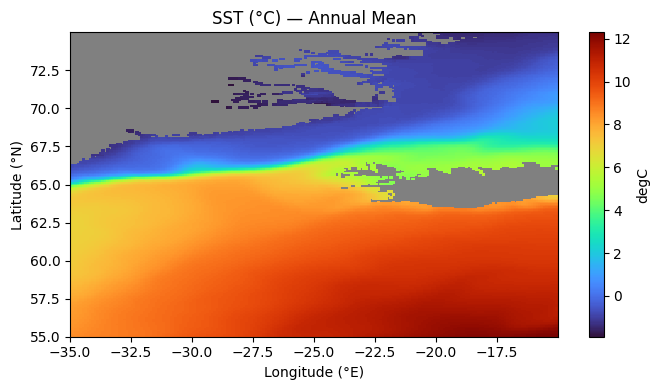

In [17]:
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolor(lon, lat, annual_mean.values, cmap='turbo')  # use cmocean.cm.thermal if available
plt.colorbar(cc, ax=ax, label='degC')
ax.set_title("SST (°C) — Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_63207/756512561.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


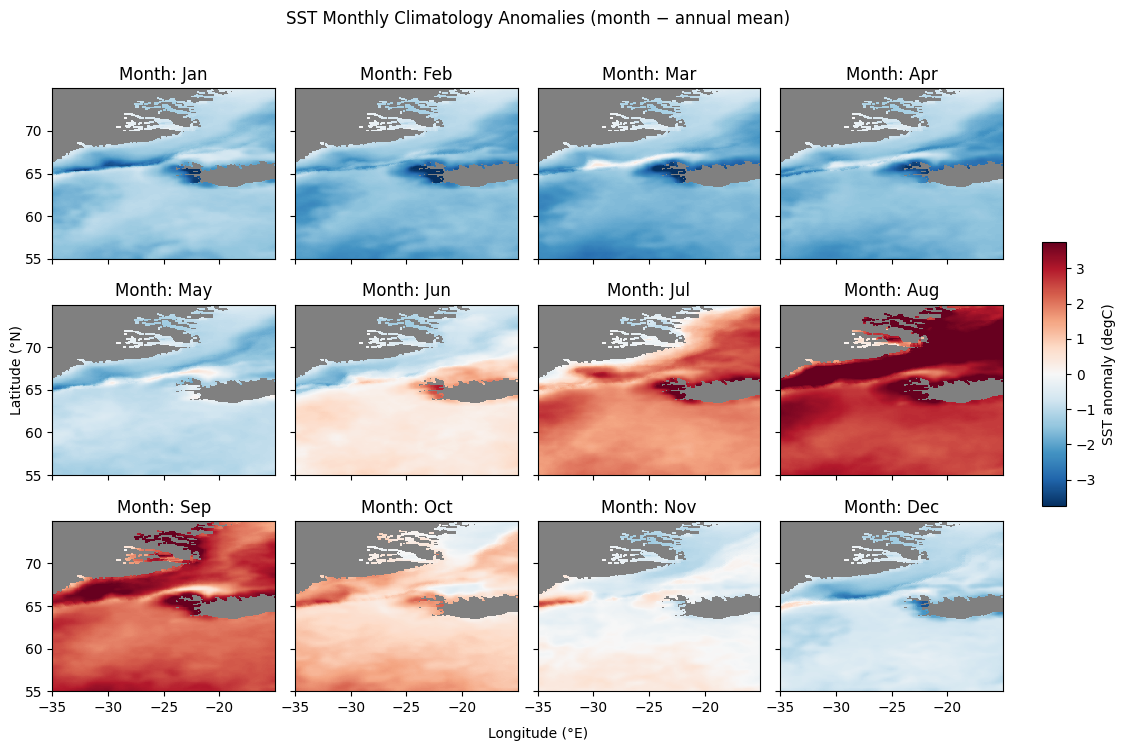

In [18]:
# Symmetric color scale using robust 98th percentile to avoid outliers
vlim = float(np.nanquantile(np.abs(seasonal_anom.values), 0.98))
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = seasonal_anom.isel(month=i).values
    cc_last = ax0.pcolor(lon, lat, da, cmap='RdBu_r', vmin=-vlim, vmax=+vlim)
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right, like the practical
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("SST anomaly (degC)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("SST Monthly Climatology Anomalies (month − annual mean)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()


In [ ]:
# Average SST 

In [ ]:
# Sectioning the ocean Basin

## Chlorophill Conecntration

Here I am using data from Copernicus-GlobColour 1977-ongoing within study range (https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_104/description)

In [35]:
dc = xr.open_dataset("../data/satellite/CMEMS_cmems_obs-oc_glo_bgc-optics_my_l4-multi-4km_P1M_2021-2024.nc")
dc
bbp = dc['BBP'] # Extracting Back scatter coefficient directly linked with chl concentrations
lat_name = "lat" if "lat" in bbp.dims else "latitude"
lon_name = "lon" if "lon" in bbp.dims else "longitude"

bbp = bbp.sel({lat_name: slice(55, 75), lon_name: slice(-35, -15)})

In [36]:
# Monthly means, 12-month climatology.
bbp_mon = bbp.resample(time='MS').mean()
bbp_clim12 = bbp_mon.groupby('time.month').mean('time')           # (month, lat, lon)
bbp_annual_mean = bbp_clim12.mean('month')                             # (lat, lon)

lon = bbp[lon_name].values
lat = bbp[lat_name].values

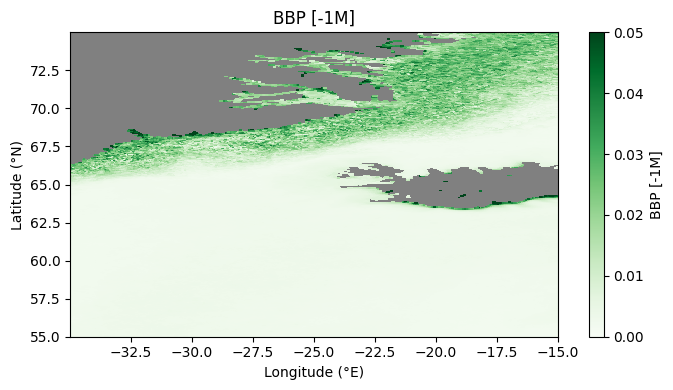

In [37]:
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolor(lon, lat, bbp_annual_mean.values, cmap='Greens',
               vmax = 0.05,
               vmin = 0)  # use cmocean.cm.thermal if available
plt.colorbar(cc, ax=ax, label='BBP [-1M]')
ax.set_title("BBP [-1M]")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_63207/356544717.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


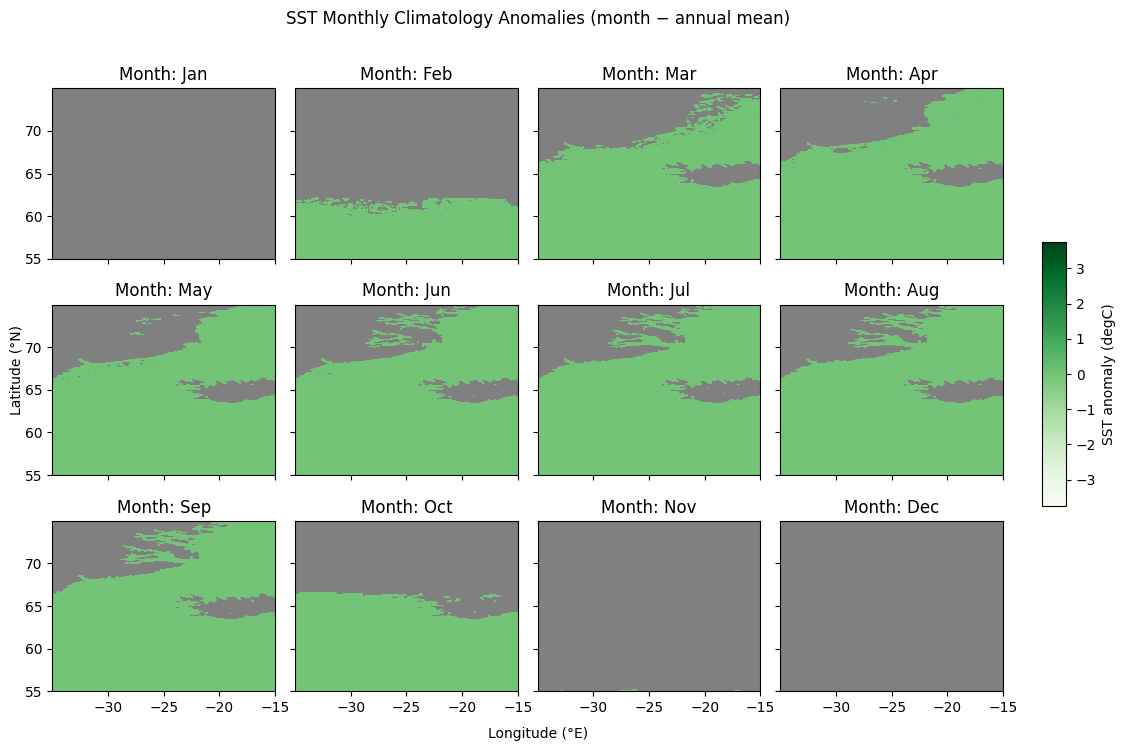

In [38]:
# Symmetric color scale using robust 98th percentile to avoid outliers
vlim = float(np.nanquantile(np.abs(seasonal_anom.values), 0.98))
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = bbp_clim12.isel(month=i).values
    cc_last = ax0.pcolor(lon, lat, da, cmap='Greens', vmin=-vlim, vmax=+vlim)
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right, like the practical
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("SST anomaly (degC)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("SST Monthly Climatology Anomalies (month − annual mean)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()